[이하은] 기본 데이터셋을 사용하여(testset 제외) CNN 모델 baseline 구성.
[이하은] 0404 기본 데이터셋과, 배경 제거한 데이터셋으로 모델을 학습하여 성능 비교, 히트맵 및 Grad-CAM을 사용하요 시각화.

구조 및 역할 : 
- Conv + Pooling: 이미지에서 점점 복잡한 특징 추출
- Flatten + Dense: 추출된 특징들을 바탕으로 분류
- Softmax 출력층: 6개 해파리 종류 중 하나로 최종 예측


## 1. 데이터 로딩

In [14]:
import tensorflow as tf

IMG_SIZE = 224
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/aiffel/aiffel/jellyfish/Train_Test_Valid/Train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/aiffel/aiffel/jellyfish/Train_Test_Valid/valid",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/aiffel/aiffel/jellyfish/Train_Test_Valid/test",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# 데이터 최적화(성능 향상)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # 한 번 읽은 데이터는 메모리에 저장하여 재사용, 학습 순서를 섰어 편향 학습 방지. 
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) # 학습 도중 다음 배치 미리 준비 -> 병럴 처리로 GPU 효율 증가.
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 900 files belonging to 6 classes.
Found 39 files belonging to 6 classes.
Found 40 files belonging to 6 classes.


In [18]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

model_8 = models.Sequential([
    # 0~255 픽셀을 0~1로 정규화
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    # 첫 번째 블록
    layers.Conv2D(32, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    # 두 번째 블록
    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    # 세 번째 블록 추가 (새로 추가)
    layers.Conv2D(128, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    # Fully connected layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # dropout 다시 활성화 (오버피팅 방지)
    layers.Dense(6, activation='softmax')  # 클래스 수: 6개
])

# 컴파일
model_8.compile(
    optimizer=Adam(learning_rate=1e-4),  # 학습률 낮춤
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 콜백 설정: val_accuracy 기준으로 최고 성능 모델 저장
checkpoint = ModelCheckpoint('best_model8.h5', monitor='val_accuracy', 
                             save_best_only=True, mode='max', verbose=1)

history = model_8.fit(
    train_ds,
    validation_data=val_ds,
    epochs=35,
    callbacks=[checkpoint]
)

Epoch 1/35
29/29 [==============================] - 3s 73ms/step - loss: 3.0807 - accuracy: 0.2656 - val_loss: 1.7844 - val_accuracy: 0.1795

Epoch 00001: val_accuracy improved from -inf to 0.17949, saving model to best_model8.h5
Epoch 2/35
29/29 [==============================] - 2s 68ms/step - loss: 1.5306 - accuracy: 0.3789 - val_loss: 1.7880 - val_accuracy: 0.1538

Epoch 00002: val_accuracy did not improve from 0.17949
Epoch 3/35
29/29 [==============================] - 2s 68ms/step - loss: 1.3532 - accuracy: 0.4600 - val_loss: 1.8098 - val_accuracy: 0.1538

Epoch 00003: val_accuracy did not improve from 0.17949
Epoch 4/35
29/29 [==============================] - 2s 68ms/step - loss: 1.1219 - accuracy: 0.5711 - val_loss: 1.7906 - val_accuracy: 0.1538

Epoch 00004: val_accuracy did not improve from 0.17949
Epoch 5/35
29/29 [==============================] - 2s 68ms/step - loss: 1.0056 - accuracy: 0.6133 - val_loss: 1.8858 - val_accuracy: 0.1795

Epoch 00005: val_accuracy did not imp

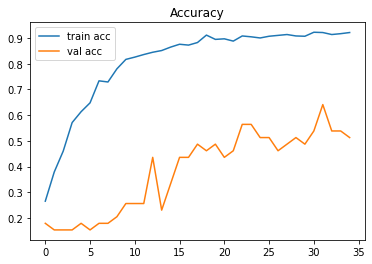

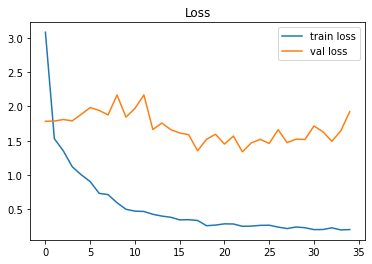

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()

## 5. testset 평가(일단 생략)

In [21]:
test_loss, test_acc = model_8.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

2/2 [==============================] - 0s 11ms/step - loss: 1.5429 - accuracy: 0.6500
Test accuracy: 0.6500, Test loss: 1.5429


                         precision    recall  f1-score   support

         Moon_jellyfish       0.80      0.67      0.73         6
       barrel_jellyfish       0.60      0.60      0.60         5
         blue_jellyfish       1.00      0.29      0.44         7
      compass_jellyfish       0.67      0.86      0.75         7
   lions_mane_jellyfish       0.58      0.88      0.70         8
mauve_stinger_jellyfish       0.57      0.57      0.57         7

               accuracy                           0.65        40
              macro avg       0.70      0.64      0.63        40
           weighted avg       0.70      0.65      0.63        40



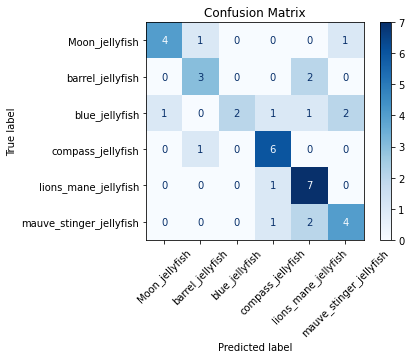

In [22]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 예측 수행
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model_8.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# 클래스 이름 (Dataset에서 자동 인식된 순서)
class_names = test_ds.class_names

# Classification Report 출력
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix 시각화
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## 내용 요약
1. 한 이미지 내에 복수 객체 존재하는 샘플이 몇개 있는지 확인.
2. 해당 이미지들을 포함해서 모델 학습 시킨 성능과, 제외하고 모델 학습을 시켰을 때 성능의 차이 존재하는가?
3. 영향이 큰지 작은지 판단하고 Grad-CAM으로 모델이 어디를 보고 학습하는지 확인해보기.(시각화)

### 1. 복수 객체 존재하는 샘플 수 확인. 
- YOLOv8을 불러와서 바운딩 박스의 개수를 카운트하여 샘플을 분류.
- 모델 로드하고 학습시키려면 바운딩 박스 처리된 이미지를 넣어서 학습시켜야하는데, 시간적 소모가 너무 크기 때문에 그냥 육안으로 다수 객체 포함된 샘플을 지우는 것으로 결정함. 

- ***-> Detection 모델을 학습하여 사용할 경우 수동으로 데이터셋에 바운딩 박스 처리해야하므로 시간 많이 결리는 것으로 판단하여,***
- ***-> 직접 육안으로 복수 객체 해파리를 제거하는 것으로 결정.***

In [27]:
# !pip install ultralytics
# from ultralytics import YOLO


In [28]:
# model = YOLO("yolov8n.pt")  # 작은 모델 (fast)
# results = model("train_ds")

# boxes = results[0].boxes
# if len(boxes) >= 2:
#     print("복수 해파리 감지됨")

### jellyfish 중복 제거 이미지셋 학습
- 복수 객체 포함된 샘플을 제거
    - 제거 기준 : 비슷한 크기의 객체가 복수 존재 시 무조건 제거.
    - 샘플 이미지에 완전한 객체 하나 + 가장자리에 애매하게 다른 객체가 보일 경우는 보류함.

Found 817 files belonging to 6 classes.
Found 39 files belonging to 6 classes.
Found 40 files belonging to 6 classes.
Epoch 1/35
26/26 [==============================] - 28s 101ms/step - loss: 3.1780 - accuracy: 0.2632 - val_loss: 1.7864 - val_accuracy: 0.1282

Epoch 00001: val_accuracy improved from -inf to 0.12821, saving model to best_model.h5
Epoch 2/35
26/26 [==============================] - 2s 69ms/step - loss: 1.4920 - accuracy: 0.3550 - val_loss: 1.8001 - val_accuracy: 0.1282

Epoch 00002: val_accuracy did not improve from 0.12821
Epoch 3/35
26/26 [==============================] - 2s 68ms/step - loss: 1.3359 - accuracy: 0.4272 - val_loss: 1.8177 - val_accuracy: 0.1282

Epoch 00003: val_accuracy did not improve from 0.12821
Epoch 4/35
26/26 [==============================] - 2s 68ms/step - loss: 1.2264 - accuracy: 0.4553 - val_loss: 1.8650 - val_accuracy: 0.2051

Epoch 00004: val_accuracy improved from 0.12821 to 0.20513, saving model to best_model.h5
Epoch 5/35
26/26 [=======

Matplotlib is building the font cache; this may take a moment.


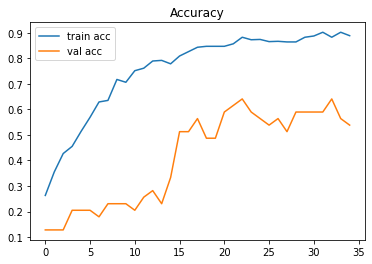

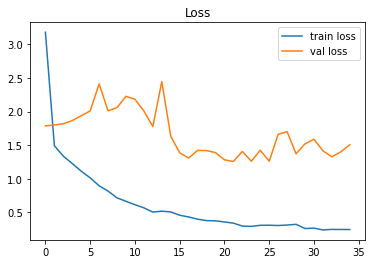

In [2]:
import tensorflow as tf

IMG_SIZE = 224
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/aiffel/aiffel/jellyfish/Train_Test_Valid_copy1/Train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/aiffel/aiffel/jellyfish/Train_Test_Valid_copy1/valid",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/aiffel/aiffel/jellyfish/Train_Test_Valid_copy1/test",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# 데이터 최적화(성능 향상)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # 한 번 읽은 데이터는 메모리에 저장하여 재사용, 학습 순서를 섰어 편향 학습 방지. 
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) # 학습 도중 다음 배치 미리 준비 -> 병럴 처리로 GPU 효율 증가.
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

model_9 = models.Sequential([
    # 0~255 픽셀을 0~1로 정규화
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    # 첫 번째 블록
    layers.Conv2D(32, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    # 두 번째 블록
    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    # 세 번째 블록 추가 (새로 추가)
    layers.Conv2D(128, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    # Fully connected layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # dropout 다시 활성화 (오버피팅 방지)
    layers.Dense(6, activation='softmax')  # 클래스 수: 6개
])

# 컴파일
model_9.compile(
    optimizer=Adam(learning_rate=1e-4),  # 학습률 낮춤
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


from tensorflow.keras.callbacks import ModelCheckpoint

# 콜백 설정: val_accuracy 기준으로 최고 성능 모델 저장
checkpoint = ModelCheckpoint('best_model9.h5', monitor='val_accuracy', 
                             save_best_only=True, mode='max', verbose=1)

history = model_9.fit(
    train_ds,
    validation_data=val_ds,
    epochs=35,
    callbacks=[checkpoint]
)

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()



2/2 [==============================] - 0s 159ms/step - loss: 1.4415 - accuracy: 0.5750
Test accuracy: 0.5750, Test loss: 1.4415
                         precision    recall  f1-score   support

         Moon_jellyfish       0.60      0.50      0.55         6
       barrel_jellyfish       0.36      0.80      0.50         5
         blue_jellyfish       0.80      0.57      0.67         7
      compass_jellyfish       0.56      0.71      0.63         7
   lions_mane_jellyfish       0.67      0.50      0.57         8
mauve_stinger_jellyfish       0.75      0.43      0.55         7

               accuracy                           0.57        40
              macro avg       0.62      0.59      0.58        40
           weighted avg       0.64      0.57      0.58        40



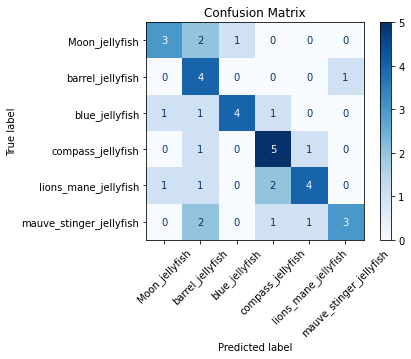

In [3]:
test_loss, test_acc = model_9.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 예측 수행
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model_9.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# 클래스 이름 (Dataset에서 자동 인식된 순서)
class_names = test_ds.class_names

# Classification Report 출력
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix 시각화
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## Grad-Cam 시각화
- 결론 : 
1. 성능 비교(정확도)
    - 복수 객체 존재하는 데이터셋을 사용하여 모델을 학습했을 시 성능이 더 높게 나왔음.
2. Grad-CAM 시각화
    - 복수 객체 존재하는 데이터셋을 사용하여 학습한 모델의 마지막 레이어의 활성도가 더 높았지만,
    - 복수 객체 샘플을 제거한 데이터셋을 사용하여 학습한 모델이 객체에 포커스를 두고 있다는 사실을 알게되었다. 
3. 추가 사항
    - 모델의 복잡도에 따라 시각화 결과가 다르게 나타날 수 있으니, 다른 모델로 검증해볼 필요가 있어보임.

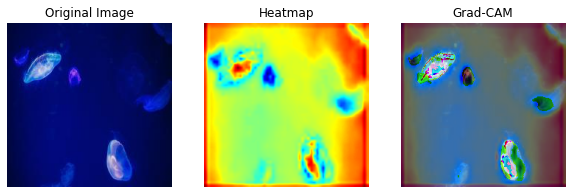

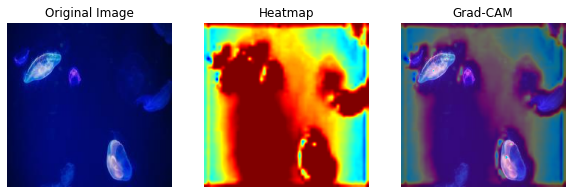

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 마지막 합성곱 층을 가져옵니다.
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    # 모델에서 마지막 합성곱 층의 출력과 모델의 예측값을 동시에 반환하는 새로운 모델을 생성합니다.
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [last_conv_layer.output, model.output]
    )
    
    # 그라디언트를 기록하기 위한 GradientTape 사용
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    # 마지막 합성곱 층의 출력에 대한 기울기를 계산합니다.
    grads = tape.gradient(class_channel, conv_outputs)
    
    # 각 필터의 중요도를 평균내어 가중치를 얻습니다.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 각 필터에 대해 가중치를 곱합니다.
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # 0~1 사이로 스케일링
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 이미지 경로와 사이즈
img_path = "/aiffel/aiffel/jellyfish/Train_Test_Valid/test/blue_jellyfish/01.jpeg"  # 분석할 이미지 파일 경로
IMG_SIZE = (224, 224)

# 이미지 배열 변환
img_array = get_img_array(img_path, IMG_SIZE)

# 모델: 여기서는 미리 학습된 모델을 사용한다고 가정 (예: MobileNetV2)
model = model_9
last_conv_layer_name = "conv2d_2"  # MobileNetV2의 마지막 합성곱 층 이름 (모델에 따라 다름)

# Grad-CAM heatmap 생성
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 원본 이미지 로드
img = image.load_img(img_path, target_size=IMG_SIZE)
img = image.img_to_array(img)

# heatmap을 원본 이미지에 오버레이
import cv2
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img.astype("uint8"))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Heatmap")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Grad-CAM")
plt.imshow(superimposed_img.astype("uint8"))
plt.axis("off")
plt.show()


#####################

model = model_8
last_conv_layer_name = "conv2d_11"  # MobileNetV2의 마지막 합성곱 층 이름 (모델에 따라 다름)

# Grad-CAM heatmap 생성
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 원본 이미지 로드
img = image.load_img(img_path, target_size=IMG_SIZE)
img = image.img_to_array(img)

# heatmap을 원본 이미지에 오버레이
import cv2
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img.astype("uint8"))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Heatmap")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Grad-CAM")
plt.imshow(superimposed_img.astype("uint8"))
plt.axis("off")
plt.show()


In [8]:
model_9.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      2

In [24]:
model_8.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
activation_9 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 112, 112, 64)     

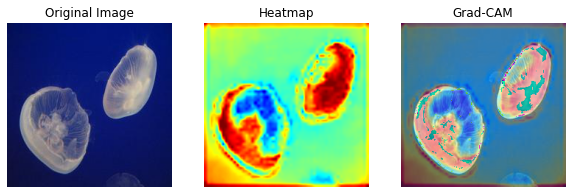

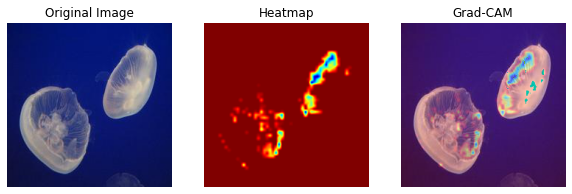

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 마지막 합성곱 층을 가져옵니다.
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    # 모델에서 마지막 합성곱 층의 출력과 모델의 예측값을 동시에 반환하는 새로운 모델을 생성합니다.
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [last_conv_layer.output, model.output]
    )
    
    # 그라디언트를 기록하기 위한 GradientTape 사용
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    # 마지막 합성곱 층의 출력에 대한 기울기를 계산합니다.
    grads = tape.gradient(class_channel, conv_outputs)
    
    # 각 필터의 중요도를 평균내어 가중치를 얻습니다.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 각 필터에 대해 가중치를 곱합니다.
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # 0~1 사이로 스케일링
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 이미지 경로와 사이즈
img_path = "/aiffel/aiffel/jellyfish/Train_Test_Valid/test/Moon_jellyfish/07.JPG"  # 분석할 이미지 파일 경로
IMG_SIZE = (224, 224)

# 이미지 배열 변환
img_array = get_img_array(img_path, IMG_SIZE)

# 모델: 여기서는 미리 학습된 모델을 사용한다고 가정 (예: MobileNetV2)
model = model_9
last_conv_layer_name = "conv2d_2"  # MobileNetV2의 마지막 합성곱 층 이름 (모델에 따라 다름)

# Grad-CAM heatmap 생성
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 원본 이미지 로드
img = image.load_img(img_path, target_size=IMG_SIZE)
img = image.img_to_array(img)

# heatmap을 원본 이미지에 오버레이
import cv2
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img.astype("uint8"))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Heatmap")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Grad-CAM")
plt.imshow(superimposed_img.astype("uint8"))
plt.axis("off")
plt.show()


#####################

model = model_8
last_conv_layer_name = "conv2d_11"  # MobileNetV2의 마지막 합성곱 층 이름 (모델에 따라 다름)

# Grad-CAM heatmap 생성
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 원본 이미지 로드
img = image.load_img(img_path, target_size=IMG_SIZE)
img = image.img_to_array(img)

# heatmap을 원본 이미지에 오버레이
import cv2
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img.astype("uint8"))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Heatmap")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Grad-CAM")
plt.imshow(superimposed_img.astype("uint8"))
plt.axis("off")
plt.show()


## 이미지 배경과 모델 학습에 관련하여
- 중복 객체 존재하는 샘플을 제외하고 학습한 모델과 제거하지 않고 학습하는 모델과 객체 초점 두는 부분에서 차이가 보였었다.
- 이것이 모델이 배경을 포함하여 학습하는 것과 연관 있는 것인지 탐구하기 위해 
- 샘플 이미지 배경을 제거하고 모델에 학습시켜,모델의 성능을 관찰하겠다. 

1. 기존 데이터셋 배경제거, 복수객체 미포함 데이터셋 배경제거
2. 모델에 각각 학습시키기
3. 시각화를 통해 성능 비교
4. 결과 마크다운 정리.

### 이미지 배경 제거한 데이터셋(복수 객체 이미지 포함)으로 model_10 학습

Found 900 files belonging to 6 classes.
Found 39 files belonging to 6 classes.
Found 40 files belonging to 6 classes.
Epoch 1/35
29/29 [==============================] - 4s 74ms/step - loss: 2.5534 - accuracy: 0.3211 - val_loss: 1.7885 - val_accuracy: 0.1795

Epoch 00001: val_accuracy improved from -inf to 0.17949, saving model to best_model10.h5
Epoch 2/35
29/29 [==============================] - 2s 69ms/step - loss: 1.3991 - accuracy: 0.4422 - val_loss: 1.8106 - val_accuracy: 0.1795

Epoch 00002: val_accuracy did not improve from 0.17949
Epoch 3/35
29/29 [==============================] - 2s 69ms/step - loss: 1.2534 - accuracy: 0.5011 - val_loss: 1.8332 - val_accuracy: 0.1538

Epoch 00003: val_accuracy did not improve from 0.17949
Epoch 4/35
29/29 [==============================] - 2s 69ms/step - loss: 1.1288 - accuracy: 0.5567 - val_loss: 1.9008 - val_accuracy: 0.0769

Epoch 00004: val_accuracy did not improve from 0.17949
Epoch 5/35
29/29 [==============================] - 2s 69ms/

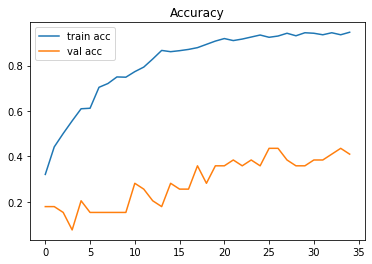

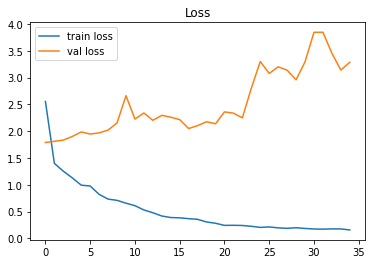

In [12]:
import tensorflow as tf

IMG_SIZE = 224
BATCH_SIZE = 32

# 배경 제거 + 복수 겍체 포함된 Train 데이터셋 
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/aiffel/aiffel/jellyfish/background_remove",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# 기존 데이터셋으로 validset
val_ds = tf.keras.utils.image_dataset_from_directory(
    "/aiffel/aiffel/jellyfish/Train_Test_Valid/valid",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
# 기존 데이터셋으로 testset
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/aiffel/aiffel/jellyfish/Train_Test_Valid/test",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# 데이터 최적화(성능 향상)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # 한 번 읽은 데이터는 메모리에 저장하여 재사용, 학습 순서를 섰어 편향 학습 방지. 
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) # 학습 도중 다음 배치 미리 준비 -> 병럴 처리로 GPU 효율 증가.
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

model_10 = models.Sequential([
    # 0~255 픽셀을 0~1로 정규화
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    # 첫 번째 블록
    layers.Conv2D(32, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    # 두 번째 블록
    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    # 세 번째 블록 추가 (새로 추가)
    layers.Conv2D(128, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    # Fully connected layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # dropout 다시 활성화 (오버피팅 방지)
    layers.Dense(6, activation='softmax')  # 클래스 수: 6개
])

# 컴파일
model_10.compile(
    optimizer=Adam(learning_rate=1e-4),  # 학습률 낮춤
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


from tensorflow.keras.callbacks import ModelCheckpoint

# 콜백 설정: val_accuracy 기준으로 최고 성능 모델 저장
checkpoint = ModelCheckpoint('best_model10.h5', monitor='val_accuracy', 
                             save_best_only=True, mode='max', verbose=1)

history = model_10.fit(
    train_ds,
    validation_data=val_ds,
    epochs=35,
    callbacks=[checkpoint]
)

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 11ms/step - loss: 3.1313 - accuracy: 0.4000
Test accuracy: 0.4000, Test loss: 3.1313
                         precision    recall  f1-score   support

         Moon_jellyfish       0.40      0.33      0.36         6
       barrel_jellyfish       0.25      0.20      0.22         5
         blue_jellyfish       0.27      0.43      0.33         7
      compass_jellyfish       0.67      0.29      0.40         7
   lions_mane_jellyfish       0.46      0.75      0.57         8
mauve_stinger_jellyfish       0.50      0.29      0.36         7

               accuracy                           0.40        40
              macro avg       0.43      0.38      0.38        40
           weighted avg       0.44      0.40      0.39        40



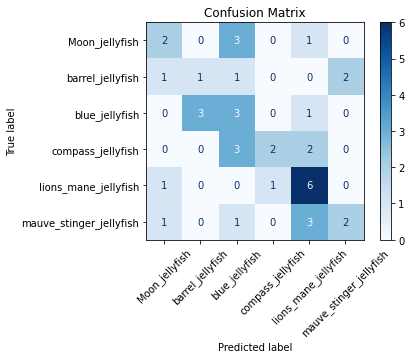

In [13]:
test_loss, test_acc = model_10.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 예측 수행
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model_10.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# 클래스 이름 (Dataset에서 자동 인식된 순서)
class_names = test_ds.class_names

# Classification Report 출력
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix 시각화
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### 이미지 배경 제거한 데이터셋(복수 객체 이미지 제외)으로 model_11 학습

Found 825 files belonging to 6 classes.
Found 39 files belonging to 6 classes.
Found 40 files belonging to 6 classes.
Epoch 1/35
26/26 [==============================] - 3s 77ms/step - loss: 2.5787 - accuracy: 0.3139 - val_loss: 1.7909 - val_accuracy: 0.2051

Epoch 00001: val_accuracy improved from -inf to 0.20513, saving model to best_model11.h5
Epoch 2/35
26/26 [==============================] - 2s 71ms/step - loss: 1.5282 - accuracy: 0.3515 - val_loss: 1.7839 - val_accuracy: 0.1538

Epoch 00002: val_accuracy did not improve from 0.20513
Epoch 3/35
26/26 [==============================] - 2s 71ms/step - loss: 1.3778 - accuracy: 0.4521 - val_loss: 1.8371 - val_accuracy: 0.1795

Epoch 00003: val_accuracy did not improve from 0.20513
Epoch 4/35
26/26 [==============================] - 2s 71ms/step - loss: 1.2538 - accuracy: 0.4764 - val_loss: 1.8330 - val_accuracy: 0.1795

Epoch 00004: val_accuracy did not improve from 0.20513
Epoch 5/35
26/26 [==============================] - 2s 71ms/

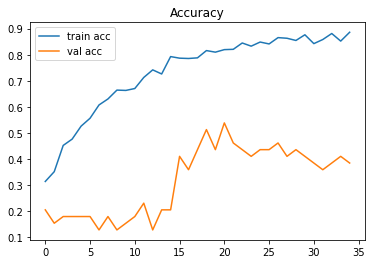

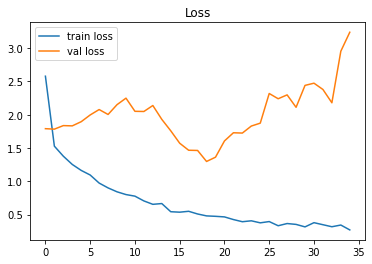

In [17]:
import tensorflow as tf

IMG_SIZE = 224
BATCH_SIZE = 32
# 배경 제거 + 복수 객체 제거 
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/aiffel/aiffel/jellyfish/background_remove_copy",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
# 기존 validset
val_ds = tf.keras.utils.image_dataset_from_directory(
    "/aiffel/aiffel/jellyfish/Train_Test_Valid/valid",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
# 기존 testset
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/aiffel/aiffel/jellyfish/Train_Test_Valid/test",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# 데이터 최적화(성능 향상)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # 한 번 읽은 데이터는 메모리에 저장하여 재사용, 학습 순서를 섰어 편향 학습 방지. 
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) # 학습 도중 다음 배치 미리 준비 -> 병럴 처리로 GPU 효율 증가.
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

model_11 = models.Sequential([
    # 0~255 픽셀을 0~1로 정규화
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    # 첫 번째 블록
    layers.Conv2D(32, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    # 두 번째 블록
    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    # 세 번째 블록 추가 (새로 추가)
    layers.Conv2D(128, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    # Fully connected layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # dropout 다시 활성화 (오버피팅 방지)
    layers.Dense(6, activation='softmax')  # 클래스 수: 6개
])

# 컴파일
model_11.compile(
    optimizer=Adam(learning_rate=1e-4),  # 학습률 낮춤
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


from tensorflow.keras.callbacks import ModelCheckpoint

# 콜백 설정: val_accuracy 기준으로 최고 성능 모델 저장
checkpoint = ModelCheckpoint('best_model11.h5', monitor='val_accuracy', 
                             save_best_only=True, mode='max', verbose=1)

history = model_11.fit(
    train_ds,
    validation_data=val_ds,
    epochs=35,
    callbacks=[checkpoint]
)

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 12ms/step - loss: 2.9269 - accuracy: 0.4250
Test accuracy: 0.4250, Test loss: 2.9269
                         precision    recall  f1-score   support

         Moon_jellyfish       0.50      0.33      0.40         6
       barrel_jellyfish       1.00      0.20      0.33         5
         blue_jellyfish       0.33      0.14      0.20         7
      compass_jellyfish       0.40      0.57      0.47         7
   lions_mane_jellyfish       0.47      0.88      0.61         8
mauve_stinger_jellyfish       0.29      0.29      0.29         7

               accuracy                           0.42        40
              macro avg       0.50      0.40      0.38        40
           weighted avg       0.47      0.42      0.39        40



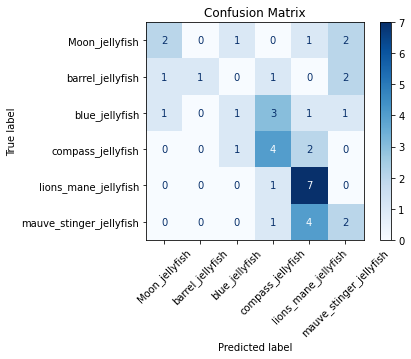

In [19]:
test_loss, test_acc = model_11.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 예측 수행
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model_11.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# 클래스 이름 (Dataset에서 자동 인식된 순서)
class_names = test_ds.class_names

# Classification Report 출력
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix 시각화
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### Grad-CAM 시각화로 성능 비교

In [24]:
model_10.summary()

print('#'*50)

model_11.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_21 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
activation_21 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_22 (Batc (None, 112, 112, 64)     

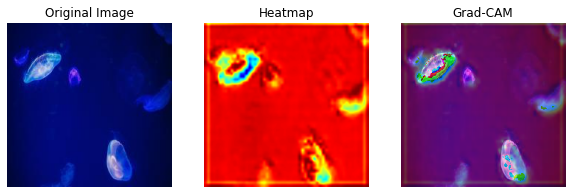

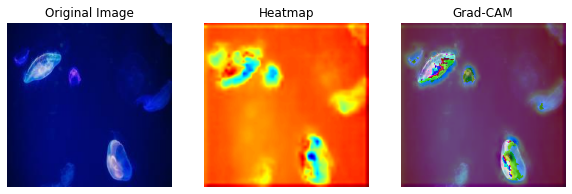

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 마지막 합성곱 층을 가져옵니다.
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    # 모델에서 마지막 합성곱 층의 출력과 모델의 예측값을 동시에 반환하는 새로운 모델을 생성합니다.
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [last_conv_layer.output, model.output]
    )
    
    # 그라디언트를 기록하기 위한 GradientTape 사용
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    # 마지막 합성곱 층의 출력에 대한 기울기를 계산합니다.
    grads = tape.gradient(class_channel, conv_outputs)
    
    # 각 필터의 중요도를 평균내어 가중치를 얻습니다.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 각 필터에 대해 가중치를 곱합니다.
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # 0~1 사이로 스케일링
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 이미지 경로와 사이즈
img_path = "/aiffel/aiffel/jellyfish/Train_Test_Valid/test/blue_jellyfish/01.jpeg"  # 분석할 이미지 파일 경로
IMG_SIZE = (224, 224)

# 이미지 배열 변환
img_array = get_img_array(img_path, IMG_SIZE)

# 모델: 여기서는 미리 학습된 모델을 사용한다고 가정 
model = model_10
last_conv_layer_name = "conv2d_23"  # 마지막 합성곱 층 이름 (모델에 따라 다름)

# Grad-CAM heatmap 생성
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 원본 이미지 로드
img = image.load_img(img_path, target_size=IMG_SIZE)
img = image.img_to_array(img)

# heatmap을 원본 이미지에 오버레이
import cv2
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img.astype("uint8"))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Heatmap")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Grad-CAM")
plt.imshow(superimposed_img.astype("uint8"))
plt.axis("off")
plt.show()


#####################

model = model_11
last_conv_layer_name = "conv2d_29"  # 마지막 합성곱 층 이름 (모델에 따라 다름)

# Grad-CAM heatmap 생성
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 원본 이미지 로드
img = image.load_img(img_path, target_size=IMG_SIZE)
img = image.img_to_array(img)

# heatmap을 원본 이미지에 오버레이
import cv2
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img.astype("uint8"))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Heatmap")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Grad-CAM")
plt.imshow(superimposed_img.astype("uint8"))
plt.axis("off")
plt.show()


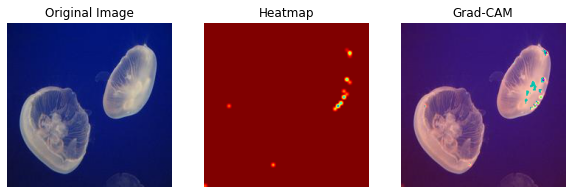

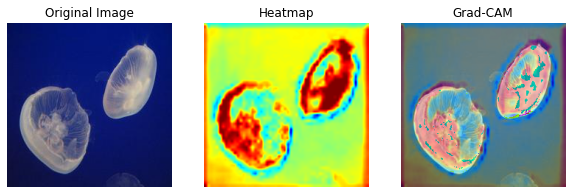

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 마지막 합성곱 층을 가져옵니다.
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    # 모델에서 마지막 합성곱 층의 출력과 모델의 예측값을 동시에 반환하는 새로운 모델을 생성합니다.
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [last_conv_layer.output, model.output]
    )
    
    # 그라디언트를 기록하기 위한 GradientTape 사용
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    # 마지막 합성곱 층의 출력에 대한 기울기를 계산합니다.
    grads = tape.gradient(class_channel, conv_outputs)
    
    # 각 필터의 중요도를 평균내어 가중치를 얻습니다.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 각 필터에 대해 가중치를 곱합니다.
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # 0~1 사이로 스케일링
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 이미지 경로와 사이즈
img_path = "/aiffel/aiffel/jellyfish/Train_Test_Valid/test/Moon_jellyfish/07.JPG"  # 분석할 이미지 파일 경로
IMG_SIZE = (224, 224)

# 이미지 배열 변환
img_array = get_img_array(img_path, IMG_SIZE)

# 모델: 여기서는 미리 학습된 모델을 사용한다고 가정 
model = model_10
last_conv_layer_name = "conv2d_23"  # 마지막 합성곱 층 이름 (모델에 따라 다름)

# Grad-CAM heatmap 생성
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 원본 이미지 로드
img = image.load_img(img_path, target_size=IMG_SIZE)
img = image.img_to_array(img)

# heatmap을 원본 이미지에 오버레이
import cv2
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img.astype("uint8"))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Heatmap")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Grad-CAM")
plt.imshow(superimposed_img.astype("uint8"))
plt.axis("off")
plt.show()


#####################

model = model_11
last_conv_layer_name = "conv2d_29"  # 마지막 합성곱 층 이름 (모델에 따라 다름)

# Grad-CAM heatmap 생성
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 원본 이미지 로드
img = image.load_img(img_path, target_size=IMG_SIZE)
img = image.img_to_array(img)

# heatmap을 원본 이미지에 오버레이
import cv2
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img.astype("uint8"))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Heatmap")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Grad-CAM")
plt.imshow(superimposed_img.astype("uint8"))
plt.axis("off")
plt.show()


#### 히트맵 & Grad-CAM 분석
1. 배경 x / 복수 객체 ㅇ 데이터셋을 학습한 모델에 대한 분석
    - Heatmap: 대부분 어두운 빨간색이고, 일부 작은 영역만 활성화돼 있음.
    - Grad-CAM: 해파리의 테두리나 아주 일부 작은 점만 강조되고 있음.
    - → 이 경우 모델은 해파리 전체가 아닌 일부 작은 영역만을 학습 근거로 삼고 있어. 이는 성능이 낮거나, 특징 추출이 잘 안 되는 상황일 수 있어. 모델이 중요한 부분을 놓치고 있을 가능성이 높음.

2. 배경 x / 복수 객체 x 
    - Heatmap: 전체적으로 밝고, 두 해파리의 내부 구조에 넓게 반응하고 있음.
    - Grad-CAM: 해파리의 내부와 외곽 부분이 뚜렷하게 강조됨.
    - → 모델이 해파리의 모양, 내부 패턴 등을 잘 인식하고 있는 상태야. Grad-CAM이 실제로 우리가 보고 있는 시각적 특징과 일치해서, 모델이 신뢰 가능한 판단 근거를 활용 중임을 의미해.

## 결론 : 
- 배경 ㅇ / 복수 객체 ㅇ
- 배경 ㅇ / 복수 객체 x
- 배경 x / 복수 객체 ㅇ
- 배경 x / 복수 객체 x
1. 이상 4가지 데이터 셋으로 학습한 모델의 성능을 비교해보면 
    - 배경 있는 샘플로 학습했을 때 정확도 조금 더 높게 나온다.
    - 복수 객체 샘플을 제외했을 때 모델이 학습한 결과로 객체에 더 잘 집중되고 인식한다.
    
2. 배경을 제거했을 때 데이터에 있는 정보가 손실되어 학습에 영향을 미친다. -> 정확도(성능) 낮아짐.

3. "배경 ㅇ / 복수 객체 x" VS "배경 x / 복수 객체 x"
    - [배경 ㅇ / 복수 객체 x]
    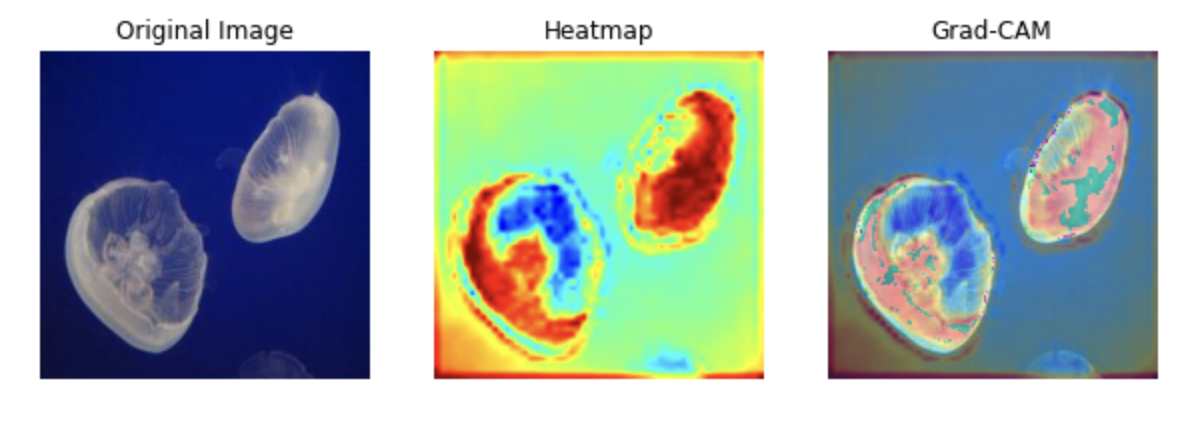
        - Heatmap:
            - 두 해파리에 대해 꽤 뚜렷한 반응을 보이고 있어.
            - 특히 아래쪽 해파리의 중앙부는 파란색, 외곽은 붉은색으로 구분되며, 내부 구조에 대해 세밀한 반응이 보임.
        - Grad-CAM:
            - 해파리 전체를 고르게 인식하고 있으며,
            - 중심과 가장자리가 다소 강조되며, 구조적 패턴까지 고려하고 있는 모습.
        - 해석: 
            -→ 모델이 단순한 외곽만이 아니라 내부 구조까지도 보고 분류하고 있음. 즉, 해파리의 시각적 특징 전체를 이해하고 있는 상태라고 볼 수 있어.

    - [배경 x / 복수 객체 x]
    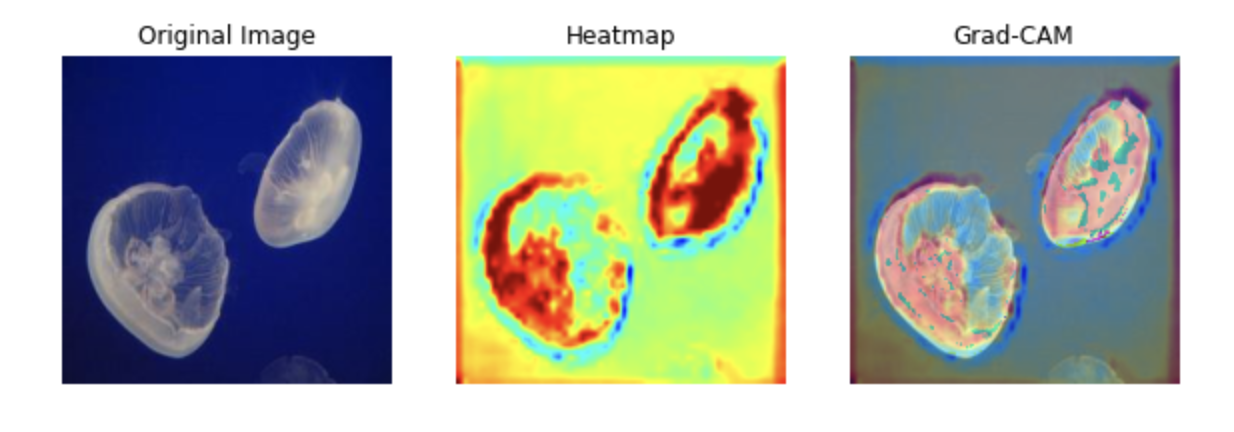
        - Heatmap:
            - 해파리 두 마리 모두에 대해 넓게 붉은 활성화가 퍼져 있음.
            - 전체적인 윤곽이 선명하게 잡혀 있고, 모델이 전체 객체에 집중하고 있음을 보여줘.
        - Grad-CAM:
            - 두 해파리의 경계와 세부 구조를 잘 강조하고 있음.
            - 특히 위쪽 해파리의 중앙 부분도 명확히 강조되어, 모델이 두 객체 모두를 적극적으로 활용하는 것으로 보임.
        - 해석:
            -→ 이 모델도 아주 효과적으로 시각 정보를 해석하고 있음. 첫 번째 이미지보다 약간 더 외곽과 테두리에 주목하는 경향이 있지만, 전반적으로 매우 양호한 수준.